In [1]:
pip install pytrec_eval

You are using pip version 19.0.2, however version 21.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Retrieval evaluation with python
#### Michael Preminger

## A notebook for demonstrating IR evaluation 

#### Made for the IR course MBIB4230 at Oslo Metropolitan University

### Using pytrec_eval by <a href="http://chri.stophr.be/">Christophe Van Gysel</a> <div class="cite2c-biblio"></div><div class="cite2c-biblio"></div> 
@inproceedings{VanGysel2018pytreceval,
  title={Pytrec\_eval: An Extremely Fast Python Interface to trec\_eval},
  author={Van Gysel, Christophe and de Rijke, Maarten},
  publisher={ACM},
  booktitle={SIGIR},
  year={2018},
}

## Before use:
* install pytrec_eval: 
  * Try **pip install pytrec_eval**.
* if pip install fails:
  * download the repository from https://github.com/cvangysel/pytrec_eval ("clone or download"), open the zip file, and run:
    * python3 setup.py build
    * python3 setup.py install

* install the elasticsearch python client: 
  * pip install elasticsearch.




* (Registered users only) Establish a tunnel for using Oslomets elasticsearch installation
  
  * MAC and Linux: 
  
    * run: ssh -N  -L 9200:localhost:9200 s******@ark2.oslomet.no -pw mbib4230
    * s****** is your student login
  * Windows: 
    * You will need the **plink** utility to connect to our elasticsearch installation while off-campus.
	  * Download the appropriate putty package from [this site](https://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html)
	  * Run the windows installer
	  * Establish an ssh-tunnell against the ark1.oslomet.no server: (can be attached to a clickable icon)
	    * open a command window (cmd.exe)
	    * run the following: 
		  * %windir%\system32\cmd.exe /C plink -N  -L 9200:localhost:9200 s******@ark2.hioa.no -pw mbib4230
		  * s****** is your student login


## How to use
Pay particular attention to the run() function under "Utility functions"

    * It has parameters with default values (for example the query file name), that you can override when calling. 
    * Comapre a couple of calls to run down the notebook with the function definition. 





### We start with a test of the pytrec_eval utility

In [2]:
import pytrec_eval 
import json
#######################################################
#======qrel is the assignment (pre judging) of relevant documents
#============= to queries, the "facit"
#######################################################
qrel = {
    'q1': {
        'd1': 0,
        'd2': 1,
        'd3': 0,
    },
    'q2': {
        'd2': 1,
        'd3': 1,
    },}

run = {
    'q1': {
        'd1': 1.0,
        'd2': 0.0,
        'd3': 1.5,
    },
    'q2': {
        'd1': 1.5,
        'd2': 0.2,
        'd3': 0.5,
    }
}

evaluator = pytrec_eval.RelevanceEvaluator(
    qrel, {'map_cut', 'ndcg_cut', 'iprec_at_recall'})

print(json.dumps(evaluator.evaluate(run), indent=1))

{
 "q1": {
  "iprec_at_recall_0.00": 0.3333333333333333,
  "iprec_at_recall_0.10": 0.3333333333333333,
  "iprec_at_recall_0.20": 0.3333333333333333,
  "iprec_at_recall_0.30": 0.3333333333333333,
  "iprec_at_recall_0.40": 0.3333333333333333,
  "iprec_at_recall_0.50": 0.3333333333333333,
  "iprec_at_recall_0.60": 0.3333333333333333,
  "iprec_at_recall_0.70": 0.3333333333333333,
  "iprec_at_recall_0.80": 0.3333333333333333,
  "iprec_at_recall_0.90": 0.3333333333333333,
  "iprec_at_recall_1.00": 0.3333333333333333,
  "ndcg_cut_5": 0.5,
  "ndcg_cut_10": 0.5,
  "ndcg_cut_15": 0.5,
  "ndcg_cut_20": 0.5,
  "ndcg_cut_30": 0.5,
  "ndcg_cut_100": 0.5,
  "ndcg_cut_200": 0.5,
  "ndcg_cut_500": 0.5,
  "ndcg_cut_1000": 0.5,
  "map_cut_5": 0.3333333333333333,
  "map_cut_10": 0.3333333333333333,
  "map_cut_15": 0.3333333333333333,
  "map_cut_20": 0.3333333333333333,
  "map_cut_30": 0.3333333333333333,
  "map_cut_100": 0.3333333333333333,
  "map_cut_200": 0.3333333333333333,
  "map_cut_500": 0.333333333

# We define classes that facilitates precision-recall curves with matplotlib

In [3]:

import re
import json

#<h2>THe NLTK-package is rich in facilities for all sorts of natural language processing, among othes Information Retrieval.</h2>

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import sys
import codecs
from elasticsearch import Elasticsearch, ElasticsearchException, SerializationError,TransportError
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pprint import pprint

# Represents a basic Precision Recall curve 
class PRCurve:
    REC_ARR=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    def __init__(self, label,  precarr, linestyle=None, color=None):
        #self.plt=plt
        self.label=label
        self.precarr=list(precarr) #DENNE LINJEN ENDRES#
        self.linestyle=linestyle
        self.color=color
        self.ydata=[]
        self.l2d=None
    
    def mp_plot(self, linestyle=None, color=None):
        if linestyle==None and color==None:
            self.l2d =plt.plot(self.REC_ARR, self.precarr, label=self.label)[0]
        else:
            self.l2d =plt.plot(x=self.REC_ARR, y=self.precarr, label=self.label, linestyle=linestyle, color=color)[0]
        return self.l2d

# Adds a label on top of a PRcurve
class CurveWithLabel:
    def __init__(self, averages, name):
        #self.plt=plt
        self.name=name
        self.averages=averages
        self.summary_measures=self.extract()
        self.label=self.make_label()
        #self.l2d=self.mp_plot()
        
    def extract(self):
        summary_measures=dict()
        for ky in list(self.averages.keys()):
            if 'iprec' not in ky:
                summary_measures.update({ky : self.averages[ky]})
                _=self.averages.pop(ky)
                
        return summary_measures
    
    def make_label(self):
        ret=self.name+":"
        for ky in self.summary_measures:
            val=self.summary_measures[ky]
            if ky == 'recip_rank':
                ky='rr'
            ret += " " + ky + "=" + str(val)[0:5] +","
        ret=ret.strip(',')    
        return ret
    
    def mp_plot(self, linestyle=None, color=None):
        
        p=PRCurve(self.label, self.averages.values(), linestyle=linestyle, color=color)
        p.mp_plot(linestyle=linestyle, color=color)
        return p.l2d
        



## Index settings (e.g. similarity function)

In [4]:
#WE ARE USING THE CLUEWEB09 INDEX WITH 50 mill web pages as documents        
INDEX_NAME = "clueweb"  # the name of the index
DOC_TYPE = "html"  # we have a single type of document, so it doesn't matter
REMOVE_STOPWORDS=True
STEM=False
#We build a JSON Configuration document for accessing Elasticsearch
#   see here: https://www.elastic.co/guide/en/elasticsearch/reference/7.5/index-modules-similarity.html#scripted_similarity
#   about changing the similarity function
### changing tfidf calc: see "scripted similarity"

INDEX_SETTINGS = {  # two shards with a single replica
    "settings" : {
        "index" : {
            "number_of_shards" : 6,
            "number_of_replicas" : 1
           #,"similarity" : { "default" : { "type" : "LMJelinekMercer", "lambda":"0.4" }
            }
        }
        ,
    "mappings": {
            "html": {
            "properties": {
#                "post_date": { "type": "date" }
#                ,
                "title": {"type": "text" }
                ,
#                "id": { "type": "keyword"}
#                ,
                "text": { "type": "text" }
                ,
                "description": {"type": "text"}
                ,
                "keywords": {"type": "keyword"}
                ,
                "classification":{"type": "text"}
                }
            }
        }
    }

### Utility functions

In [5]:
import pytrec_eval
import sys
import json
import matplotlib.patches as mpatches
es = Elasticsearch("localhost:9200", log="trace", timeout=1000)
print(es)

def run(es=es, 
        index="clueweb", 
        queryfile="q156-160_brief.txt", 
        similarity="DFR", 
        parameterNames=["basic_model", "after_effect", "normalization", "normalization.h2.c"], 
        parameterValues=["g",          "l",            "h2", "4.0"]
       ):
    es.indices.close(index=index)
    val_dict={"type":similarity}
    for i in range(len(parameterNames)):
        val_dict[parameterNames[i]]=parameterValues[i]
        
    
    def_dict={"default":val_dict}
    sim_dict= {"similarity": def_dict}
    setting_dict={"index":sim_dict}
    similarity_setting=json.JSONEncoder().encode(setting_dict)
    print("setting::")
    print(similarity_setting)
    
    es.indices.put_settings(index=index, body=similarity_setting)
    es.indices.open(index=index)
    es.indices.refresh(index=index)
    
    old_setting=es.indices.get_settings(index=index, name="similarity")
    print(old_setting)
#    sys.exit()

    qrels=dict()
    with open("qrels.adhoc", 'r') as myfile: #, errors='replace'
            qrel_lines=myfile.readlines()

    for line in qrel_lines:
        qnr, zero, docnr, rel=line.split()
        if qnr not in qrels.keys():
            qrels[qnr]=dict()
        qrels[qnr][docnr]=int(rel)

    queries=dict()
    with open(queryfile) as qfile:
        qlines=qfile.readlines()

    for line in qlines:
        qnr, qstring=line.split(':')
        qstring=qstring.strip('\n')
        if qnr not in queries.keys():
            queries[qnr]=qstring

    run=dict()    
    for qr in queries.keys():
        query=queries[qr]
        res = es.search(index=INDEX_NAME, q=query, _source=False, size=1000)
        for hit in res['hits']['hits']:
    #        print("Doc ID: %3r  Score: %5.2f" % (hit['_id'], hit['_score']))
            if qr not in run.keys():
                run[qr]=dict()
            run[qr][hit['_id']]=hit['_score']    

    evaluator = pytrec_eval.RelevanceEvaluator(
        qrels, { 'iprec_at_recall', 'map', 'ndcg', 'Rprec','recip_rank'}) #, 'map', 'ndcg',
    eval=evaluator.evaluate(run)


    avres=dict()

    for q in eval.keys():
        for res in eval[q].keys():
            if res not in avres.keys():
                avres[res]=0 #initialize
            avres[res]+=eval[q][res]/len(eval)#update average
        
    return avres

def plotCombined(cwls):
    if len(cwls) > 10:
        print("Too many plots attempted. Sorry")
        sys.exit()
    colors=['red', 'aqua', 'darkmagenta', 'sienna', 'brown', 'grey', 'cyan', 'lawngreen', 'darkgoldenrod', 'deepskyblue']
    linestyles=['-', '--', '-.', '.', ':', '-', '--', '-.', '.', ':']
    l2ds=list()
    ax=None
    for c in range(len(cwls)):
        cwl=cwls[c]
        ls=linestyles[c]
        color=colors[c]
       
        l2ds.append(cwl.mp_plot())
        
    plt.legend()
    plt.show()

curvesWithLabels=list()

<Elasticsearch([{'host': 'localhost', 'port': 9200}])>


## Running and plotting

setting::
{"index": {"similarity": {"default": {"type": "classic"}}}}
{}
setting::
{"index": {"similarity": {"default": {"type": "LMJelinekMercer", "lambda": "0.4"}}}}
{}


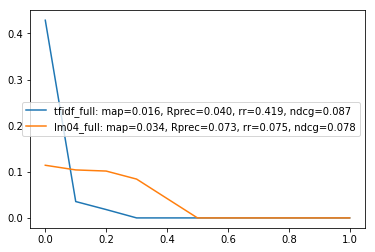

In [7]:
curvesWithLabels=list()
avres1=run(es,             
          similarity="classic",
          queryfile="q156-160_full.txt",
          parameterNames=[],      #No parameters here
          parameterValues=[])
tfidf_f=CurveWithLabel(avres1, "tfidf_full")
curvesWithLabels.append(tfidf_f)
#________________________________________________________
avres2=run(es, 
          index="clueweb", 
          queryfile="q156-160_full.txt",
          similarity="LMJelinekMercer",
          parameterNames=["lambda"], 
          parameterValues=["0.4"]) 

lm04_f=CurveWithLabel(avres2, "lm04_full")
curvesWithLabels.append(lm04_f)     

plotCombined(curvesWithLabels)

setting::
{"index": {"similarity": {"default": {"type": "classic"}}}}
{}
setting::
{"index": {"similarity": {"default": {"type": "LMJelinekMercer", "lambda": "0.4"}}}}
{}


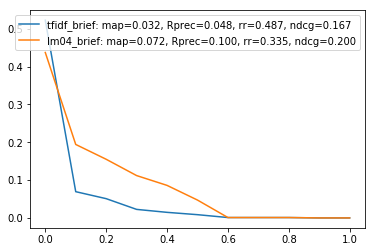

In [9]:
curvesWithLabels=list()
avres1=run(es,             
          similarity="classic",
          queryfile="q156-160_brief.txt",
          parameterNames=[],      #No parameters here
          parameterValues=[])
tfidf_b=CurveWithLabel(avres1, "tfidf_brief")
curvesWithLabels.append(tfidf_b)
#________________________________________________________
avres2=run(es, 
          index="clueweb", 
          queryfile="q156-160_brief.txt",
          similarity="LMJelinekMercer",
          parameterNames=["lambda"], 
          parameterValues=["0.4"]) 

lm04_b=CurveWithLabel(avres2, "lm04_brief")
curvesWithLabels.append(lm04_b)     

plotCombined(curvesWithLabels)